In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from lib import jsoncorpus, datastuff, analysis
import gensim
import traceback
import numpy as np
import matplotlib.pyplot as plt
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.svm
import sklearn.decomposition
import sklearn.cluster
from lib.scikitComponents import *
import itertools
import collections
import sklearn.metrics

# LDA

## Data preprocessing

In [19]:
# Load in the previously created corpus and dictionary of scraped sites
dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl')

Done.


In [20]:
# Build a list of all topics
allcategories = set(tuple(t) for t in dmoz_data['dmoz_categories'])
# Build a list of all top-level topics
topcategories = set(topic[0] for topic in dmoz_data['dmoz_categories'])
# Link topics to URLs
meta = list(zip(dmoz_data['urls'], dmoz_data['dmoz_categories']))
# Represent the topics in an alternative way
heirarchal_categories = lambda max_depth: [['; '.join(topics[:ti+1]) for ti, t in enumerate(topics) if ti < max_depth] for topics in dmoz_data['dmoz_categories']]
# Top categories
top_categories = [x[0] for x in heirarchal_categories(1)]

## Define a classification pipeline for the corpus data

The Pipeline() object chains together objects from the lib.scikitComponents file, so that they can be used as part of a scikit-learn classification pipeline

In [21]:
def lda_feature_pipeline(num_topics):
    return sklearn.pipeline.Pipeline([
            ('lda_model', LDAModel(dictionary, num_topics)),
            ('matrix_builder', TopicMatrixBuilder(num_topics))
            ])

Define a classifier (decision trees), and chain the preprocessing step to the classifier

In [22]:
classifier = sklearn.ensemble.ExtraTreesClassifier(random_state=0, n_estimators=100, oob_score=True, bootstrap=True, n_jobs=4)
#classifier = sklearn.tree.DecisionTreeClassifier()#(random_state=0, n_estimators=100, oob_score=True, bootstrap=True, n_jobs=4)

clf = sklearn.pipeline.Pipeline([
    ('preprocess_meta', lda_feature_pipeline(len(topcategories))),
    ('classification', classifier)])

## Process the dmoz categories
In this case, we will just turn the top category in to an index

In [23]:
dmoz_encoder = sklearn.preprocessing.LabelEncoder().fit(top_categories)
classes = dmoz_encoder.transform(top_categories)
print classes

[7 7 7 ..., 3 3 3]


In [24]:
X = np.array(corpus)
y = classes

### Build a training and test set

This may either be done from the full dataset, *or* from a dataset with **equal class proportions**.

In [25]:
PROPORTIONAL = False
if PROPORTIONAL:
    prop_X, prop_y = datastuff.make_proportional(X, y, min_size=200)
    
    ind_train, ind_test = next(iter(sklearn.cross_validation.StratifiedShuffleSplit(prop_y, test_size = 0.25)))
    X_train , X_test, y_train, y_test = (prop_X[ind_train], prop_X[ind_test], prop_y[ind_train], prop_y[ind_test])
else:
    X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y)
counts =collections.Counter(y_test)
"".join(["{}: {}     ".format(dmoz_encoder.inverse_transform(k), counts[k]) for k in counts.keys()])

'arts: 33     business: 44     computers: 58     games: 17     health: 44     home: 38     kids and teens: 18     news: 31     recreation: 44     reference: 48     regional: 2     science: 45     shopping: 40     society: 41     sports: 97     '

## Run the classifier

We can use the meta corpus or the full body corpus here, just by replacing a single argument

The data is split in to training and test sets, and then fit to the training set. The LDA model is generated ***only*** from the training set, not the testing set.

In [26]:
#model = clf.fit(X_train, y_train)
#print model.score(X_test, y_test)
#sklearn.cross_validation.cross_val_score(clf, corpus, classes)
scores = sklearn.cross_validation.cross_val_score(clf, X, classes, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.33 (+/- 0.06)


### Find the score for each category. 

Note that if the classifier assigned *random* categories, the score would be $\frac{1}{\textrm{num categories}}$. Instead, it is actually quite high in some casses, indicating a moderate ammount of succcess (given how naive this is!)

In [13]:
category_scores = collections.defaultdict(float)
category_counts = collections.defaultdict(float)
predicted = model.predict(X_test)
for real, pred in sorted(zip(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted))):
    category_scores[real] += 1 if real == pred else 0
    category_counts[real] += 1 

In [14]:
print sklearn.metrics.classification_report(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)


             precision    recall  f1-score   support

       arts       0.36      0.13      0.19        38
   business       0.33      0.33      0.33        52
  computers       0.47      0.39      0.42        62
      games       0.43      0.14      0.21        22
     health       0.25      0.21      0.23        33
       home       0.32      0.40      0.36        30
kids and teens       0.40      0.27      0.32        15
       news       0.53      0.51      0.52        39
 recreation       0.33      0.15      0.21        47
  reference       0.31      0.41      0.36        41
   regional       0.00      0.00      0.00         1
    science       0.34      0.27      0.30        45
   shopping       0.56      0.62      0.59        29
    society       0.22      0.16      0.19        43
     sports       0.46      0.85      0.60       103

avg / total       0.39      0.40      0.37       600



/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


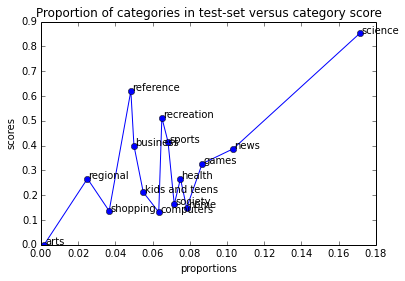

In [15]:
data = np.array(sorted([
            (category_counts[cat]/len(y_test), category_scores[cat] / category_counts[cat]) 
            for cat in category_counts.keys()
        ])).T
plt.plot(*data, marker='o')
plt.xlabel('proportions')
plt.ylabel('scores')
plt.title('Proportion of categories in test-set versus category score')
i = -1
for s, tx, ty in zip(category_counts.keys(), *data):
    if PROPORTIONAL:
        tx = -0.0005+tx+i*0.001
    else:
        tx+=0.001
    plt.text(tx, ty, s)
    i*=-1
plt.show()

[[ 5  2  3  0  2  0  0  3  1  6  0  2  1  4  9]
 [ 0 17  7  0  3  3  1  1  2  2  0  2  4  0 10]
 [ 2 11 24  0  2  1  1  2  0  2  0  7  1  3  6]
 [ 0  0  1  3  0  1  1  0  2  0  0  0  0  0 14]
 [ 0  4  1  0  7  4  1  2  2  3  0  3  0  2  4]
 [ 1  4  1  0  4 12  0  1  1  1  0  0  1  2  2]
 [ 1  0  1  0  0  1  4  0  1  3  0  0  0  1  3]
 [ 3  1  2  2  1  0  0 20  1  0  0  1  0  0  8]
 [ 0  2  1  0  0  5  0  0  7  7  0  1  2  2 20]
 [ 2  0  1  0  0  2  1  3  1 17  0  2  2  5  5]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  4  6  0  0  2  0  2  0  4  0 12  0  5 10]
 [ 0  4  1  0  0  1  0  0  0  1  0  0 18  1  3]
 [ 0  1  1  1  7  3  1  4  0  6  0  3  1  7  8]
 [ 0  1  1  1  2  2  0  0  3  1  0  2  2  0 88]]


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


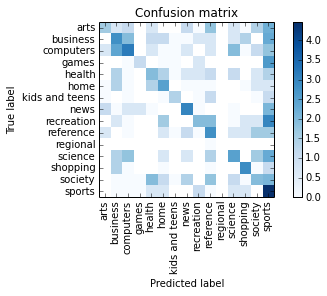

In [16]:
cm = sklearn.metrics.confusion_matrix(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)
analysis.plot_confusion_matrix(np.log(cm), labels= dmoz_encoder.classes_)


print cm